## Trajectory Optimization of a Skateboard Model
### Phase 3: Airborne

<img src = "images/skateboard_phase3.png" width = "300">

In [33]:
# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# DERIVE EOMS OF BOARD --------------------------------------------------------------------------------------------------------

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb = sym.symbols('m_{board}') # mass
lb = sym.symbols('l_{board}') # length of board
lbr = sym.symbols('l_{wheels}') # length between reaction forces
hb = sym.symbols('h_{board}') # height - board clearance
Inb = sym.symbols('In_{board}') # moment of intertia

# generalized coordinates
x,y,thb = sym.symbols(['x','y','\\theta_{board}']) 
dx,dy,dthb = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{board}']) 
ddx,ddy,ddthb = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{board}']) 

q = sym.Matrix([[x],[y],[thb]])
dq = sym.Matrix([[dx],[dy],[dthb]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb]])

#display(ddq)

# forces
F_FF,F_BF = sym.symbols(['F_{FF}','F_{BF}']) # front and back foot applied forces

# STEP 1: position vectors ri = [x,y] (world frame)
rb = sym.Matrix([[x],
                [y]])
# the Jacobians
Jb = rb.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([mb,mb])

T = 0.5*sym.transpose(Mb)*sym.matrix_multiply_elementwise(vb,vb)
T = T[0] + 0.5*Inb*dthb**2
V = mb*g*rb[1]

#display(T) #display(V)

# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces -----------------------------------------------------------------------------------------------

# applied forces
F1 = sym.Matrix([[0],[-F_BF]])
F2 = sym.Matrix([[0],[-F_FF]])

# # distance of forces
rF1 = sym.Matrix([[x - 0.5*lbr*sym.cos(thb)],
                  [y - 0.5*lbr*sym.sin(thb)]])

rF2 = sym.Matrix([[x + 0.5*lbr*sym.cos(thb)],
                  [y + 0.5*lbr*sym.sin(thb)]])

JF1 = rF1.jacobian(q)
JF2 = rF2.jacobian(q)

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = F1.transpose()*JF1[:,j]+F2.transpose()*JF2[:,j]

#display(Q)

# Calculate equations of motion
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
display(sym.solve(EOMs, [ddq[0],ddq[1],ddq[2]]))

In [34]:
# Simulate Dynamics -----------------------------------------------------------------------------------------------------------
#initial conditions
x0 = 0
y0 = 1
thb0 = np.pi/4
dx0 = 0
dy0 = 6
dthb0 = -2

h = 0.01

#parameters
lbval = 0.84
lbrval = 0.48
mbval = 2
Inbval = 1/12*mbval*lbval**2
gval = 9.81
F_FFval = 0
F_BFval = 0
hbval = 0.11

parameter_values = [(g,gval),(mb,mbval),(lb,lbval),(lbr,lbrval),(Inb,Inbval),(F_BF,F_BFval),(F_FF,F_FFval)]

xar = [x0]
yar = [y0]
thar = [thb0]
dxar = [dx0]
dyar = [dy0]
dthar = [dthb0]

N = 100
for i in range(1,N):
    # add a backfoot force halfway through simulation
    if (i>50):
        parameter_values = [(g,gval),(mb,mbval),(lb,lbval),(lbr,lbrval),(Inb,Inbval),(F_BF,10),(F_FF,F_FFval)]
    
    # substitute parameter values and previous conditions into the EOM 
    past = [(q[0],xar[i-1]),(q[1],yar[i-1]),(q[2],thar[i-1]),(dq[0],dxar[i-1]),(dq[1],dyar[i-1]),(dq[2],dthar[i-1])]
    EOM_sub = EOM.subs(parameter_values).subs(past)
    
    # solve for the acceleration
    acc = sym.solve(EOM_sub, [ddq[0],ddq[1],ddq[2]])
    
    # integrate for the next velocity and position    
    dxar.append(float(dxar[i-1]+h*acc[ddq[0]]))
    dyar.append(float(dyar[i-1]+h*acc[ddq[1]]))
    dthar.append(float(dthar[i-1]+h*acc[ddq[2]]))
    xar.append(float(xar[i-1]+h*dxar[i]))
    yar.append(float(yar[i-1]+h*dyar[i]))
    thar.append(float(thar[i-1]+h*dthar[i]))


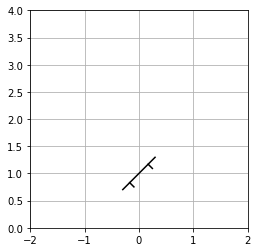

In [19]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
fig1.gca().set_aspect('equal', adjustable='box') #make x,y scales equal

def plot_board(i,x_in,y_in,th_in,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-2,2])
    ax.set_ylim([0,4])
    ax.grid()
    
    #plot skateboard
    boardLx = x_in[i]-0.5*lbval*np.cos(th_in[i])
    boardLy = y_in[i]-0.5*lbval*np.sin(th_in[i])
    boardRx = x_in[i]+0.5*lbval*np.cos(th_in[i])
    boardRy = y_in[i]+0.5*lbval*np.sin(th_in[i])
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')
    
    #plot left wheel
    leftwheelTopx = x_in[i]-0.5*lbrval*np.cos(th_in[i])
    leftwheelTopy = y_in[i]-0.5*lbrval*np.sin(th_in[i])
    leftwheelBottomx = leftwheelTopx + hbval*np.sin(th_in[i])
    leftwheelBottomy = leftwheelTopy - hbval*np.cos(th_in[i])
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')
    
    #plot right wheel
    rightwheelTopx = x_in[i]+0.5*lbrval*np.cos(th_in[i])
    rightwheelTopy = y_in[i]+0.5*lbrval*np.sin(th_in[i])
    rightwheelBottomx = rightwheelTopx + hbval*np.sin(th_in[i])
    rightwheelBottomy = rightwheelTopy - hbval*np.cos(th_in[i])
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')
    
update = lambda i: plot_board(i,xar,yar,thar,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(N),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [20]:
# Lambdify EOMs
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,lb,lbr,Inb,
            x,y,thb,
            dx,dy,dthb,
            ddx,ddy,ddthb,
            F_FF,F_BF]
            
lambEOMx = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOMy = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOMthb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])

In [21]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 20
m.N = RangeSet(N)

DOFs = ['x','y','thb'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81) # gravity
m.mb = Param(initialize = 2.0) # mass of board
m.lb = Param(initialize = 0.84) # length of board
m.lbr = Param(initialize = 0.48) # length between wheels
m.hb = Param(initialize = 0.11) # board clearance

BW = m.mb.value*m.g.value # body weight used for scaling

def calculate_In(m): 
     return m.mb*m.lb**2/3 
m.Inb = Param(initialize = calculate_In) # moment of inertia

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# forces
m.F_FF = Var(m.N, bounds = (0.0, None)) # Force from front foot > 0
m.F_BF = Var(m.N, bounds = (0.0, None)) # Force from back foot > 0

# auxillary variables
m.btail = Var(m.N, m.DOF) # back of board
m.bnose = Var(m.N, m.DOF) # front of board

def def_btail(m,n,dof):
    if dof == 'y':
        return m.btail[n, 'y'] == m.q[n,'y'] - 0.5*m.lb*sin(m.q[n,'thb']) 
    if dof == 'x':
        return m.btail[n, 'x'] == m.q[n,'x'] - 0.5*m.lb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_btail = Constraint(m.N, m.DOF,rule = def_btail)

def def_bnose(m,n,dof):
    if dof == 'y':
        return m.bnose[n, 'y'] == m.q[n,'y'] + 0.5*m.lb*sin(m.q[n,'thb']) 
    if dof == 'x':
        return m.bnose[n, 'x'] == m.q[n,'x'] + 0.5*m.lb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_bnose = Constraint(m.N, m.DOF,rule = def_bnose)
    
# bound variables
for n in range(1,N+1):
    m.bnose[n,'y'].setlb(0.0)
    m.btail[n,'y'].setlb(0.0)
    m.q[n,'y'].setlb(m.hb)
    m.q[n,'thb'].setub(np.pi/2)
    m.q[n,'thb'].setlb(-np.pi/2)

In [22]:
# TIME AND INTEGRATION --------------------------------------------------------------------------------------------------------

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n-1,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

In [23]:
# EOMs ------------------------------------------------------------------------------------------------------------------------

# sym_list = [g,mb,lb,lbr,Inb,
#             x,y,thb,
#             dx,dy,dthb,
#             ddx,ddy,ddthb,
#             F_FF,F_BF]

#create the constraints
def EOMx(m,n): # for x
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb,
               m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'],
               m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.F_FF[n], m.F_BF[n]] 
    return lambEOMx(*var_list) == 0
m.EOMx = Constraint(m.N, rule = EOMx)

def EOMy(m,n): # for y
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb,
               m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'],
               m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.F_FF[n], m.F_BF[n]]
    return lambEOMy(*var_list) == 0
m.EOMy = Constraint(m.N, rule = EOMy)

def EOMthb(m,n): # for theta
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb,
               m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'],
               m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.F_FF[n], m.F_BF[n]]
    return lambEOMthb(*var_list) == 0
m.EOMthb = Constraint(m.N, rule = EOMthb)

In [24]:
# # HIGH DROP -----------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'y'].value = 5.0
# m.q[1,'thb'].value = 0.0

# for dof in DOFs:
#     m.q[1,dof].fixed = True
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
    
# for n in range(1,N+1):
#     m.F_BF[n].value = 0.0
#     m.F_BF[n].fixed = True
#     m.F_FF[n].value = 0.0
#     m.F_FF[n].fixed = True
    
# #m.pprint()

In [25]:
# # RISE, SPIN -----------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'y'].value = 1.0
# m.q[1,'thb'].value = np.pi/4
# m.dq[1,'x'].value = 0.0
# m.dq[1,'y'].value = 8.0
# m.dq[1,'thb'].value = -1.0

# for dof in DOFs:
#     m.q[1,dof].fixed = True
#     m.dq[1,dof].fixed = True
    
# for n in range(1,N+1):
#     m.F_BF[n].value = 0.0
#     m.F_BF[n].fixed = True
#     m.F_FF[n].value = 0.0
#     m.F_FF[n].fixed = True
    
# #m.pprint()

In [26]:
# AIRBORNE -----------------------------------------------------------------------------------------------------------------
# Start the board at an angle and initial vertical velocity and see if it flattens out

# initial condition
m.q[1,'x'].value = 0.0
m.btail[1,'y'].value = 0.0
m.q[1,'thb'].value = np.pi/4
m.dq[1,'x'].value = 0.0
m.dq[1,'y'].value = 4.0
m.dq[1,'thb'].value = 0.0

m.btail[1,'y'].fixed = True

for dof in DOFs:
    if dof != 'y':
        m.q[1,dof].fixed = True
    m.dq[1,dof].fixed = True
    
# final conditions
m.q[N,'thb'].value = 0.0
m.q[N,'thb'].fixed = True
m.dq[N,'thb'].value = 0.0
m.dq[N,'thb'].fixed = True
m.F_BF[N].value = 0.0
m.F_BF[N].fixed = True
m.F_FF[N].value = 0.0
m.F_FF[N].fixed = True


# # initialize
thb_guide = np.linspace(np.pi/4,0.0,N)
for n in range(1,N-1):
    m.q[n,'thb'].value = thb_guide[n]

In [27]:
# COST FUNCTION ---------------------------------------------------------------------------------------------------------------
# minimum time and minimum reaction penalties

def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    force_sum = 0
    for n in range(1,N+1):
        force_sum += m.F_BF[n]
        force_sum += m.F_FF[n]
    return T+1000*force_sum
m.Cost = Objective(rule = CostFun)

In [28]:
# Solve -----------------------------------------------------------------------------------------------------------------------
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 300 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 

Ipopt 3.11.1: expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=300
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      827
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      165

Total number of variables............................:      310
                     variables with only l

In [29]:
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

ok
optimal


In [30]:
#m.btail.pprint()

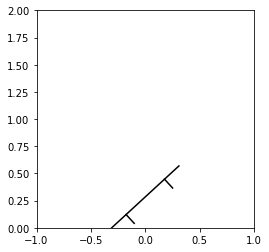

In [31]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_board(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,1])
    ax.set_ylim([0,2])
    
    #plot skateboard
    boardLx = m.btail[i,'x'].value
    boardLy = m.btail[i,'y'].value
    boardRx = m.bnose[i,'x'].value
    boardRy = m.bnose[i,'y'].value
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')
    
    #plot left wheel
    leftwheelTopx = m.q[i,'x'].value-0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    leftwheelTopy = m.q[i,'y'].value-0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    leftwheelBottomx = leftwheelTopx + m.hb*np.sin(m.q[i,'thb'].value)
    leftwheelBottomy = leftwheelTopy - m.hb*np.cos(m.q[i,'thb'].value)
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')
    
    #plot right wheel
    rightwheelTopx = m.q[i,'x'].value+0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    rightwheelTopy = m.q[i,'y'].value+0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    rightwheelBottomx = rightwheelTopx + m.hb*np.sin(m.q[i,'thb'].value)
    rightwheelBottomy = rightwheelTopy - m.hb*np.cos(m.q[i,'thb'].value)
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')
    
update = lambda i: plot_board(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


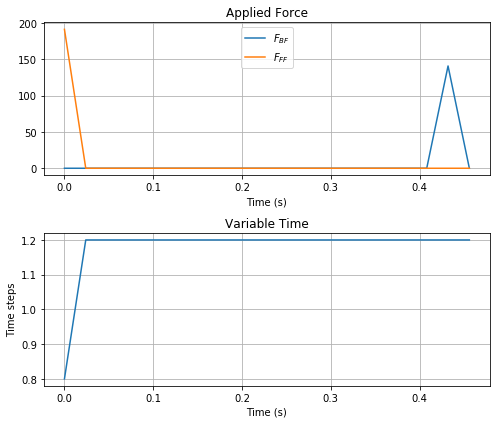

In [32]:
# Plot some of the variables
F_BFar = [m.F_BF[i]() for i in range(1,N+1)]
F_FFar  = [m.F_FF[i]() for i in range (1,N+1)]
tarr = [m.h[i]() for i in range (1,N+1)]

t = hm*np.cumsum(np.asarray(tarr))
t -= t[0]

plt.figure(figsize=(7, 6))
plt.subplot(2,1,1)
plt.plot(t, F_BFar)
plt.plot(t, F_FFar)
plt.title('Applied Force')
plt.xlabel('Time (s)')
plt.legend([r'$F_{BF}$',r'$F_{FF}$'])
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t,tarr)
plt.title('Variable Time')
plt.xlabel('Time (s)')
plt.ylabel('Time steps')
plt.grid(True)

plt.tight_layout()